In [1]:
pip install XGBoost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import precision_recall_cutoff
import Ensemble
from xgboost import XGBClassifier
from cost_function import cost_function, cost_function_cutoff
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


# Reading the csv file
train = pd.read_csv('train_dataset.csv')

# Defining the file to be read from s3 bucket
test = pd.read_csv('test_dataset.csv')
test = test.dropna()
test.shape

(498121, 44)

In [3]:
train.shape

(1879, 45)

In [4]:
# Defining input and target variables
test = test[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9', 'heredity_2', 'interaction_5']]
X = train[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9', 'heredity_2', 'interaction_5']]
Y = train['fraud']

# Splitting the data into train, test, and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)


# Scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

X_val = scaler.fit_transform(X_val)
X_val = pd.DataFrame(X_val, columns = X.columns)


X_val

,totalScanTimeInSeconds,interaction_1,interaction_4,heredity_1,interaction_9,heredity_2,interaction_5
0,0.795167,0.0,0.0,0.0,0.0,0.0,0.409091
1,0.482153,1.0,0.0,1.0,1.0,0.6,0.736364
2,0.172433,0.0,1.0,0.0,0.0,0.0,0.363636
3,0.475014,0.0,1.0,0.0,0.0,0.0,0.000000
4,0.823723,0.0,0.0,0.0,0.0,0.0,0.454545
...,...,...,...,...,...,...,...
371,0.542010,0.0,1.0,0.0,0.0,0.0,0.000000
372,0.641406,0.0,1.0,0.0,0.0,0.0,0.381818
373,0.325645,0.0,1.0,0.0,0.0,0.0,0.081818
374,0.491488,0.0,1.0,0.0,0.0,0.0,0.318182


In [5]:
# Defining top 7, 6, and 5 variables
# Train dataset
X_train_7 = X_train
X_train_6 = X_train[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9', 'heredity_2']]
X_train_5 = X_train[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9']]

# Validation dataset
X_val_7 = X_val
X_val_6 = X_val[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9', 'heredity_2']]
X_val_5 = X_val[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9']]

# Validation dataset
test_7 = test
test_6 = test[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9', 'heredity_2']]
test_5 = test[['totalScanTimeInSeconds', 'interaction_1', 'interaction_4', 'heredity_1', 'interaction_9']]


### The Best Random Forest Model

In [6]:
RF_md = RandomForestClassifier(max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=500).fit(X_train_5, Y_train)

# Predicting on validation and test
RF_val_pred = RF_md.predict_proba(X_val_5)[:,1]
RF_test_pred = RF_md.predict_proba(test_5)[:,1]

RF_val_pred

array([6.34425695e-02, 3.45903504e-01, 3.05951260e-04, 1.30326426e-04,
       6.96263314e-02, 8.51401738e-03, 1.30326426e-04, 1.30326426e-04,
       1.30326426e-04, 1.30326426e-04, 1.30326426e-04, 8.78068356e-03,
       1.30326426e-04, 1.30326426e-04, 1.30326426e-04, 7.34066873e-03,
       3.05951260e-04, 3.05951260e-04, 7.34066873e-03, 1.30326426e-04,
       1.05995195e-02, 9.70221843e-03, 7.24115392e-02, 3.05951260e-04,
       1.15503812e-02, 7.74864425e-02, 3.05951260e-04, 3.05951260e-04,
       1.20392697e-01, 3.05951260e-04, 3.05951260e-04, 7.26560255e-03,
       1.30326426e-04, 1.30326426e-04, 7.16504389e-03, 7.16504389e-03,
       7.26560255e-03, 4.48865067e-03, 1.30326426e-04, 3.05951260e-04,
       7.34066873e-03, 3.05951260e-04, 1.17774997e-02, 1.30326426e-04,
       1.30326426e-04, 5.60049139e-03, 7.26560255e-03, 3.20734777e-01,
       1.30326426e-04, 1.30326426e-04, 1.30326426e-04, 1.30326426e-04,
       1.30326426e-04, 4.86386434e-03, 3.05951260e-04, 3.05951260e-04,
      

### The Best Support Vector Machine Model

In [7]:
SVC_md = SVC(C=0.01, gamma=0.1, kernel='sigmoid', probability=True).fit(X_train_5, Y_train)

# Predicting on validation and test
SVC_val_pred = SVC_md.predict_proba(X_val_5)[:,1]
SVC_test_pred = SVC_md.predict_proba(test_5)[:,1]

SVC_test_pred

array([9.55931110e-06, 1.13497364e-05, 5.71314970e-07, ...,
       4.77270189e-06, 1.13602435e-05, 1.13601806e-05])

### The Best AdaBoost Model

In [8]:
ADA_md = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_leaf=5,
                                                         min_samples_split=10),
                                                         learning_rate=0.01, n_estimators=300).fit(X_train_7, Y_train)
# Predicting on validation and test
ADA_val_pred = ADA_md.predict_proba(X_val_7)[:,1]
ADA_test_pred = ADA_md.predict_proba(test_7)[:,1]

ADA_test_pred

array([0.00575177, 0.00300118, 0.24346475, ..., 0.00359437, 0.29229956,
       0.00765619])

### The Best XGBClassifier Model

In [9]:
XGBoost_md = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=5,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None).fit(X_train_5, Y_train)

# Predicting on validation and test
XGBoost_val_pred = XGBoost_md.predict_proba(X_val_5)[:,1]
XGBoost_test_pred = XGBoost_md.predict_proba(test_5)[:,1]

XGBoost_val_pred

array([0.07866494, 0.2813576 , 0.00471826, 0.00473181, 0.08012717,
       0.01504919, 0.00473181, 0.00473181, 0.00473181, 0.00473181,
       0.00473181, 0.00781996, 0.0047653 , 0.00473181, 0.00473181,
       0.01416493, 0.00471826, 0.00471826, 0.01404937, 0.00473181,
       0.00739508, 0.00781996, 0.08669376, 0.00471826, 0.00770581,
       0.08631069, 0.00471826, 0.00471826, 0.16302054, 0.00471826,
       0.00471826, 0.01195419, 0.00473181, 0.00473181, 0.01556974,
       0.01182399, 0.01199116, 0.00633378, 0.00473181, 0.00471826,
       0.01436112, 0.00471826, 0.00781996, 0.00473181, 0.00473181,
       0.00633378, 0.01199116, 0.40415278, 0.00473181, 0.0047653 ,
       0.00473181, 0.00473181, 0.00473181, 0.00633378, 0.00471826,
       0.00471826, 0.01309801, 0.01195932, 0.00473181, 0.00471826,
       0.00628474, 0.01225273, 0.00683016, 0.01556974, 0.00781996,
       0.08631069, 0.16634002, 0.00471826, 0.00473181, 0.01193186,
       0.00471826, 0.59467536, 0.39908063, 0.00473181, 0.00471

In [10]:
esemble_train = pd.DataFrame({'RF': RF_val_pred, "SVC": SVC_val_pred, 'ADA': ADA_val_pred, "XGBoost": XGBoost_val_pred, "Y_val": Y_val})
esemble_train.head()

,RF,SVC,ADA,XGBoost,Y_val
61,0.063443,0.016323,0.186937,0.078665,0
1218,0.345904,0.533785,0.649164,0.281358,1
1876,0.000306,0.000045,0.000017,0.004718,0
1279,0.000130,0.000715,0.000827,0.004732,0
1254,0.069626,0.021152,0.125807,0.080127,0


In [11]:
esemble_test = pd.DataFrame({"RF_preds_test": RF_test_pred, "SVC_preds_test": SVC_test_pred, "ADA_preds_test": ADA_test_pred, "XGBoost_preds_test": XGBoost_test_pred})
esemble_test.head()

,RF_preds_test,SVC_preds_test,ADA_preds_test,XGBoost_preds_test
0,0.009702,9.559311e-06,0.005752,0.00782
1,0.009702,1.134974e-05,0.003001,0.00782
2,0.138982,5.713150e-07,0.243465,0.16634
3,0.009702,1.036345e-05,0.004993,0.00782
4,0.009702,1.132827e-05,0.017044,0.00782


In [12]:
import Ensemble
RF_val_pred = pd.DataFrame(RF_val_pred)
SVC_val_pred = pd.DataFrame(SVC_val_pred)
ADA_val_pred = pd.DataFrame(ADA_val_pred)
XGBoost_val_pred = pd.DataFrame(XGBoost_val_pred)
Y = esemble_train['Y_val']
RF_test_pred = pd.DataFrame(RF_test_pred)
SVC_test_pred = pd.DataFrame(SVC_test_pred)
ADA_test_pred = pd.DataFrame(ADA_test_pred)
XGBoost_test_pred = pd.DataFrame(XGBoost_test_pred)

ensemble = Ensemble.ensemble(RF_val_pred, SVC_val_pred, ADA_val_pred, XGBoost_val_pred, Y, RF_test_pred, SVC_test_pred, ADA_test_pred, XGBoost_test_pred)


Working on job 1 out of  48
Working on job 2 out of  48
Working on job 3 out of  48
Working on job 4 out of  48
Working on job 5 out of  48
Working on job 6 out of  48
Working on job 7 out of  48
Working on job 8 out of  48
Working on job 9 out of  48
Working on job 10 out of  48
Working on job 11 out of  48
Working on job 12 out of  48
Working on job 13 out of  48
Working on job 14 out of  48
Working on job 15 out of  48
Working on job 16 out of  48
Working on job 17 out of  48
Working on job 18 out of  48
Working on job 19 out of  48
Working on job 20 out of  48
Working on job 21 out of  48
Working on job 22 out of  48
Working on job 23 out of  48
Working on job 24 out of  48
Working on job 25 out of  48
Working on job 26 out of  48
Working on job 27 out of  48
Working on job 28 out of  48
Working on job 29 out of  48
Working on job 30 out of  48
Working on job 31 out of  48
Working on job 32 out of  48
Working on job 33 out of  48
Working on job 34 out of  48
Working on job 35 out o

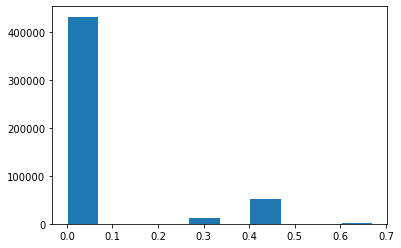

In [13]:
plt.hist(ensemble)
plt.show()

In [14]:
ensemble = pd.DataFrame(ensemble)

In [18]:
Predictions = pd.concat([RF_test_pred, SVC_test_pred, ADA_test_pred, XGBoost_test_pred, ensemble], axis = 1)
Predictions.columns = ['RF_test_pred', 'SVC_test_pred', 'ADA_test_pred', "XGBoost_test_pred", 'Ensemble']
Predictions

,RF_test_pred,SVC_test_pred,ADA_test_pred,XGBoost_test_pred,Ensemble
0,0.009702,9.559311e-06,0.005752,0.007820,0.002125
1,0.009702,1.134974e-05,0.003001,0.007820,0.002125
2,0.138982,5.713150e-07,0.243465,0.166340,0.010169
3,0.009702,1.036345e-05,0.004993,0.007820,0.002125
4,0.009702,1.132827e-05,0.017044,0.007820,0.002125
...,...,...,...,...,...
498116,0.009702,1.126980e-05,0.017044,0.007820,0.002125
498117,0.948023,6.210312e-06,0.876374,0.863096,0.410486
498118,0.009702,4.772702e-06,0.003594,0.007820,0.002125
498119,0.138982,1.136024e-05,0.292300,0.166340,0.010169


In [16]:
likelyhoods = pd.DataFrame({'Likelyhoods': Predictions['Ensemble']})
likelyhoods.head()

,Likelyhoods
0,0.002125
1,0.002125
2,0.010169
3,0.002125
4,0.002125


In [19]:
### The cutoff is 0.95

In [17]:
likelyhoods.to_csv("likelyhoods.csv", index = False)

# Indentifyung the optimal cut-off value
opt_cutoff = cost_function_cutoff(Y_val, SVC_val_pred)

# Changing the likelihoods to labels
SVC_label = np.where(SVC_test_pred < opt_cutoff, 0, 1)

# Computing the confusion matrix
X = confusion_matrix(Y_test, SVC_label)
print(X)
print('The cost of the SVC model is: ', -1500*X[1,0] - 1000*X[0,1] + 500*X[1, 1])